In [1]:
import warnings
import pandas as pd
from matplotlib import pyplot as plt
from aeon.visualisation import plot_series
from sklearn.metrics import mean_absolute_percentage_error as mape
from all_functions import *
import os
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
warnings.filterwarnings("ignore")
%matplotlib inline

/home/anp/anaconda3/lib/python3.11/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [2]:
def generate_index(start_date, end_date):
    end_date_dt = pd.to_datetime(end_date)
    
    start_date_dt = pd.to_datetime(start_date)
    
    index = pd.period_range(start=start_date_dt, end=end_date_dt, freq='M')

    return index

def get_train_real(series, start_date):
    start_period = pd.to_datetime(start_date).to_period('M')
    
    filtered_series = series[series.index < start_period]

    return filtered_series

def get_preds_hybrid(path, test_date, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    filtered_df = df[df['test_range'] == test_date]
    columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    values_list = columns_p1_to_p12.values.flatten().tolist()     
    results = pd.Series(values_list, index=start_index)
    return results


def save_csv(nome, csv_file, uf, derivado, models, series, test, preds, horizon=12, window=12):
    y_baseline = series[-horizon*2:-horizon].values
    rmse_result = rmse(test, preds)
    mape_result = mape(test, preds)
    pocid_result = pocid(test, preds)
    pbe_result = pbe(test, preds)
    mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
    mase_result = mase(test, preds, y_baseline)

    df_result = pd.DataFrame({'DATA': nome, 'UF': uf, 'PRODUCT': derivado, 'MODEL':  f"{'_'.join(models)}", 'PARAMS': str({}), 'WINDOW': window, 'HORIZON': horizon,  
                                            'RMSE': rmse_result, 'MAPE': mape_result, 'POCID': pocid_result, 'PBE': pbe_result, 'MASE': mase_result,
                                            'P1': preds[0], 'P2': preds[1], 'P3': preds[2], 'P4': preds[3], 'P5': preds[4],
                                            'P6': preds[5], 'P7': preds[6], 'P8': preds[7], 'P9': preds[8], 'P10': preds[9],
                                            'P11': preds[10], 'P12': preds[11]
                                            }, index=[0])
    df_result.to_csv(csv_file, sep=';', mode='a', header=False, index=False)


In [3]:
dirs = [
    '../datasets/venda/mensal/uf/gasolinac/',
    '../datasets/venda/mensal/uf/etanolhidratado/',
    '../datasets/venda/mensal/uf/glp/',
    '../datasets/venda/mensal/uf/oleodiesel/',
]
horizon = 12
window = 12

In [4]:
models = ["ETS","catboost", "arima", "rf"]
transformations = ["normal"]
dates = [
        '1993-03_1994-02',
        '1994-03_1995-02', '1995-03_1996-02', '1996-03_1997-02', '1997-03_1998-02', '1998-03_1999-02',
        '1999-03_2000-02', '2000-03_2001-02', '2001-03_2002-02', '2002-03_2003-02', '2003-03_2004-02',
        '2004-03_2005-02', '2005-03_2006-02', '2006-03_2007-02', '2007-03_2008-02', '2008-03_2009-02',
        '2009-03_2010-02', '2010-03_2011-02', '2011-03_2012-02', '2012-03_2013-02', '2013-03_2014-02',
        '2014-03_2015-02', '2015-03_2016-02', '2016-03_2017-02', '2017-03_2018-02', '2018-03_2019-02',
        '2019-03_2020-02', '2020-03_2021-02', '2021-03_2022-02', '2022-03_2023-02', '2023-03_2024-02',
         
         ]

data_features = pd.DataFrame()

column_mapping = {}
col_index = 0

for model in models:
    for transform in transformations:
        column_mapping[(model, transform)] = col_index
        col_index += 1


produto = "gasolinac"
estado = "SP"
regr = "rf"
for directory in dirs:
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            uf = file.split("_")[1].upper()
            derivado = file.split("_")[2].split(".")[0]
            
            if uf == estado and produto == derivado:
                full_path = os.path.join(directory, file)
                series = read_series(full_path)

                for date in dates:
                    start_date, end_date = date.split('_')
                    test_index = generate_index(start_date, end_date)
                    test_real = get_test_real(series, start_date, end_date)
                    row_data = []
                    for model in models:
                        for transform in transformations:
                            serie_pred = get_preds_hybrid(f'./results/{model}/{derivado}/{transform}/transform_{uf}.csv', date, test_index)
                            row_data.extend(serie_pred.values)

                    row_data.extend(test_real.values)

                    new_row = pd.DataFrame([row_data])
                    data_features = pd.concat([data_features, new_row], ignore_index=True)
                
                X = data_features.iloc[:, :-horizon].values
                y = data_features.iloc[:, -horizon:].values
                X_train = X[:-1]
                y_train = y[:-1]
                X_test = X[-1].reshape(1, -1)
                y_test = y[-1]
                if regr == "rf":
                    model = RandomForestRegressor(random_state=42)

                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)
                print(y_pred)                

[[884086.25859 862760.4391  866020.17105 827295.59958 826323.91842
  856607.51339 819850.94852 865741.01573 835669.52201 942080.60481
  812515.79783 791176.0692 ]]


In [5]:
X = data_features.iloc[:, :-horizon].values
y = data_features.iloc[:, -horizon:].values
X_train = X[:-1]
y_train = y[:-1]
X_test = X[-1].reshape(1, -1)
y_test = y[-1]

In [6]:
model = RandomForestRegressor()
# model.fit(X_train, y_train)

growth_factor=500
weights = (np.exp(np.linspace(0, 1, len(X_train)) * np.log(growth_factor)) - 1) / (growth_factor - 1)
model.fit(X_train, y_train, sample_weight=weights)
y_pred = model.predict(X_test)

In [7]:
model2 = RandomForestRegressor()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

In [8]:
test_data = '2023-03_2024-02'
start_date, end_date = test_data.split('_')
test_index = generate_index(start_date, end_date)
arima = get_preds_hybrid(f'./results/{models[0]}/{produto}/normal/transform_{estado}.csv', test_data, test_index)
catboost = get_preds_hybrid(f'./results/{models[1]}/{produto}/normal/transform_{estado}.csv', test_data, test_index)
ETS = get_preds_hybrid(f'./results/{models[2]}/{produto}/normal/transform_{estado}.csv', test_data, test_index)


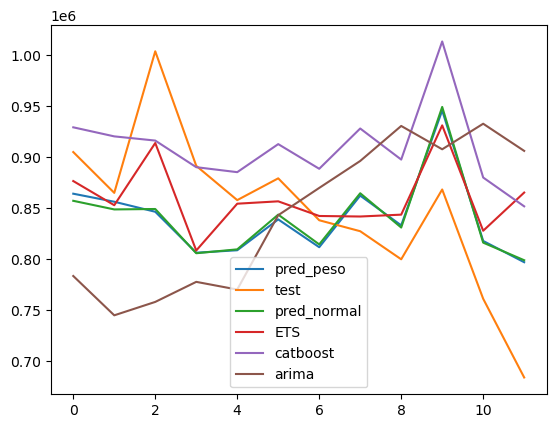

In [ ]:
plt.plot(y_pred[0], label="pred_peso")
plt.plot(y_test, label="test")
plt.plot(y_pred2[0], label="pred_normal")
plt.plot(ETS.values, label=f"{models[0]}")
plt.plot(arima.values, label=f"{models[1]}")
plt.plot(catboost.values, label=f"{models[2]}")

plt.legend()
plt.show()